# Summary statistics of the raw data

Create 26/11 to separate the creaton of the results files and cleanup the processing steps

This notebook creates the summary statistics to describe the raw data (measurements from imageJ outputs).


|  Name |  symbol   | Short description |
|-------|-----------|-------------------|
|       |           |                   |

In [3]:
#matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import models 
import importlib
import indexTools
import pymc3 as pm
import bee_util as bu
importlib.reload(models)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<module 'models' from '/Users/evenhuis/Dropbox/MIF/Workflows/bee_quant/analysis/models.py'>

## Read in the data

In [4]:
results_dir = "results_analyse/"
from glob import glob
import os
files=sorted(glob(results_dir+"cont_*.csv"))+\
    sorted(glob(results_dir+'caged*.csv'))+\
    sorted(glob(results_dir+'banked*.csv'))
import data_handling as dh
df = dh.read_data(files)

# add integer labels for the various groupings 
df['i_ind'],     df['ucode']   = indexTools.multilabel_encoder(df,'treat day rep string'.split())
df['i_treatday'],df['treatday']= indexTools.multilabel_encoder(df,'treat day'.split())
df['i_treat'],_                = indexTools.multilabel_encoder(df,'treat'.split())
#df.to_csv('merged_data.csv')

ind = df['i_ind']
nind = len(np.unique(ind))

treatday = df['i_treatday']
ntreatday = len(np.unique(treatday))

ind_in_treatday = indexTools.embeded_index(df,'i_ind','i_treatday')

## Crossing metric
Return when two lines cross one another

In [5]:
def get_crossing_metrics(x,ylow,yhigh):
    '''returns the location and size of ylow crosses yhigh where yo=yn'''
    if( np.all(x[1:]-x[:-1]<0) ): # increasing x
        return get_crossing_metrics(x[::-1],ylow[::-1],yhigh[::-1])
    # find the crossing point
    
    diffs = ylow-yhigh
    imin = np.argmin( diffs<0)
    if( imin==0 ):
        return x[imin],ylow[imin]        

    d1,d2 = diffs[imin],diffs[imin-1] # difference each side
    x1,x2 = x[[imin,imin-1]]
    y1,y2 = ylow[[imin,imin-1]]
    f = d2/(d2-d1)
    xc,yc = f*x1+(1-f)*x2, f*y1+(1-f)*y2      
    return xc,yc

In [6]:
thresh = 15  # threshold for increase in cell size
import pandas as pd
columns='i_ind treat day rep string i_treatday '+\
        'ncell V_oc_max V_oc_last V_ns_max V_ns_last V_ns_diff '+\
        'min_pos V_min_oc V_min_ns V_min_diff '+\
        'eq_pos V_eq inc_o inc_n'
df_size=pd.DataFrame(columns=columns.split(),dtype=float)
df_size.set_index('i_ind',inplace=True)
for iexp,itreatday in enumerate(ind_in_treatday):
    #print(iexp,itreatday)
    mask = df['i_ind']==iexp
    dft = df[mask]
    
    df_size.loc[iexp,'treat':'string'] = dft.loc[:,'treat':'string'].iloc[0]
    pos = dft['pos'].values
    
    df_size.loc[iexp,'i_treatday':'ncell']=(itreatday,len(dft))

    x     = -np.array(dft['pos'].values)
    yo    =  np.array(dft['Oc_size'].values)
    yn    =  np.array(dft['Ns_size'].values)
    diffs = yo-yn
    
    #df_size.loc[iexp,'V_oc_max':'V_oc_min']=(max(dft['Oc_size']),min(dft['Oc_size']))
    #df_size.loc[iexp,'V_ns_max':'V_ns_min']=(max(dft['Ns_size']),min(dft['Ns_size']))
    
    #df_size.loc[iexp,'V_oc_max':'V_oc_min']=dft['Oc_size'].values[[0,-1]]
    #df_size.loc[iexp,'V_ns_max':'V_ns_min']=dft['Ns_size'].values[[0,-1]]
    
    df_size.loc[iexp,'V_oc_max']  = max(yo)
    df_size.loc[iexp,'V_oc_last'] = yo[0]
    
    df_size.loc[iexp,'V_ns_max']  = max(yn)
    df_size.loc[iexp,'V_ns_last'] = yn[0]
    df_size.loc[iexp,'V_ns_diff'] = max(yn)-yn[0]
    

    # find the crossing point
    xc,yc = get_crossing_metrics(x,yo,yn) 
    df_size.loc[iexp,'eq_pos']=-xc
    df_size.loc[iexp,'V_eq']  = yc    

    # create the threshold increase for the oocyte
    vmin = min(yo)
    ymins = x*0 + vmin*(1+thresh/100.)
    xinc_o,yinc_o = get_crossing_metrics( x, yo,ymins )
    df_size.loc[iexp,'inc_o']=-xinc_o
    
    # create the threshold increase for the nurse
    vmin = min(yn)
    ymins = x*0 + vmin*(1+thresh/100.)
    xinc_o,yinc_o = get_crossing_metrics( x, yo,ymins )
    df_size.loc[iexp,'inc_n']=-xinc_o 
        
    
    
    # biggest difference between cells
    imin= np.argmin(diffs) 
    x,yom,ynm=x[imin],yo[imin],yn[imin]
    df_size.loc[iexp,'min_pos' ]=-x
    df_size.loc[iexp,'V_min_oc']=yom
    df_size.loc[iexp,'V_min_ns']=ynm
    df_size.loc[iexp,'V_min_diff']=yom-ynm

    # max nurse
    imax = pos[np.argmax(yn)]
    x,y1=pos[imax],yn[imax]
    
    
df_size.to_csv('raw_data_summary_stats.csv') 

## Preview the Results 

In [7]:
df_size

,treat,day,rep,string,i_treatday,ncell,V_oc_max,V_oc_last,V_ns_max,V_ns_last,V_ns_diff,min_pos,V_min_oc,V_min_ns,V_min_diff,eq_pos,V_eq,inc_o,inc_n
i_ind,,,,,,,,,,,,,,,,,,,
0.0,cont,0.0,1.0,1.0,0.0,13.0,372.031071,372.031071,200.263686,56.247137,144.016549,6.0,111.895891,173.890478,-61.994587,3.693622,196.199883,12.000000,8.829213
1.0,cont,0.0,1.0,2.0,0.0,11.0,275.698432,275.698432,208.361870,208.361870,0.000000,3.0,122.165157,185.620079,-63.454922,1.237977,201.718977,9.045615,4.724432
2.0,cont,0.0,1.0,3.0,0.0,15.0,331.978583,331.978583,198.748394,198.748394,0.000000,6.0,61.307313,128.712077,-67.404764,1.956065,170.485586,13.113217,5.599823
3.0,cont,0.0,2.0,1.0,0.0,16.0,495.021665,495.021665,250.004319,71.320587,178.683732,6.0,74.552928,139.819053,-65.266125,2.701597,233.670842,14.894934,8.644569
4.0,cont,0.0,2.0,2.0,0.0,14.0,504.132351,504.132351,250.029918,95.893473,154.136444,6.0,67.889634,134.187064,-66.297430,2.567846,221.331351,13.000000,7.630905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69.0,banked,10.0,4.0,1.0,4.0,7.0,357.941917,357.941917,200.974066,200.974066,0.000000,3.0,86.919190,145.373171,-58.453981,0.865999,193.786483,5.842166,2.570359
70.0,banked,10.0,4.0,2.0,4.0,7.0,456.776444,456.776444,202.651092,69.921774,132.729317,3.0,102.206251,161.700452,-59.494201,1.723922,192.117047,5.638402,4.122991
71.0,banked,10.0,4.0,3.0,4.0,9.0,463.159232,463.159232,210.469088,93.269661,117.199427,2.0,136.769959,192.864117,-56.094157,1.596611,199.965770,7.813146,3.406889


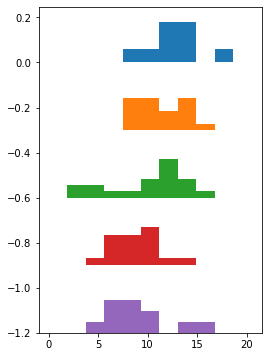

In [10]:
fig,ax = plt.subplots(1,1,figsize=(4,6))
for i in range(5):
    ax.hist(df_size.loc[df_size['i_treatday']==i,'inc_o'],bins=np.linspace(0,20.5,12),density=True,bottom=-0.3*i)